In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
import pandas as pd
import numpy as np

In [3]:
print(tf.__version__)

2.7.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/sample_data/data.csv", index_col=0)

df.head()

,main_text,target,text2
0,Oil prices behind downward revisions to inflat...,1,oil price behind downward revision inflation e...
1,The European Central Bank (ECB) today publishe...,1,european central bank ecb today publishes dece...
2,"353,000 counterfeit euro banknotes were withdr...",1,counterfeit euro banknote withdrawn circulatio...
3,The Governing Council of the European Central ...,1,governing council european central bank today ...
4,The Governing Council of the European Central ...,1,governing council european central bank ecb de...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 0 to 1215
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   main_text  1215 non-null   object
 1   target     1216 non-null   int64 
 2   text2      1215 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.0+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215 entries, 0 to 1215
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   main_text  1215 non-null   object
 1   target     1215 non-null   int64 
 2   text2      1215 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.0+ KB


In [7]:
df = df.sample(1215)

In [8]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [9]:
sentences = df.text2.to_list()
type(sentences)

list

In [10]:
training_size= 1215
test_portion=.1
split = int(test_portion * training_size)

In [11]:
testing_sentences = sentences[0:split]
training_sentences = sentences[split:training_size]


In [12]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [13]:
labels = df.target.to_list()
test_labels = labels[0:split]
training_labels = labels[split:training_size]
training_labels = np.array(training_labels)
testing_labels = np.array(test_labels)

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? ? ? july executive board ecb decided proposal directorate general research request evaluation economic research activity ecb three independent external expert marvin goodfriend reiner könig rafael repullo invited act evaluator given specific term reference final report delivered february released today report give balanced account achievement since establishment ecb whole report provides positive assessment research conducted ecb several criterion scientific quality value added relevance conduct monetary policy task function ecb influence academic community institution requested term reference evaluator also made number useful recommendation five area incentive staff conduct research ii management human capital iii coverage coordination research activity different business area ecb iv research support v communication dissemination research report available ecb website http
july executive board ecb decided proposal directorate general research request evaluation economic r

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64, activation="relu", return_sequences=True),
    tf.keras.layers.LSTM(32,),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 120, 64)           20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 193,185
Trainable params: 193,185
Non-trainable params: 0
_________________________________________________________________


In [18]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)

In [16]:
num_epochs = 100
history = model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/100
35/35 [==============================] - 9s 155ms/step - loss: 0.6935 - accuracy: 0.4872 - val_loss: 0.6932 - val_accuracy: 0.4793
Epoch 2/100
35/35 [==============================] - 4s 122ms/step - loss: 0.6926 - accuracy: 0.5375 - val_loss: 0.6925 - val_accuracy: 0.5702
Epoch 3/100
35/35 [==============================] - 4s 123ms/step - loss: 0.6791 - accuracy: 0.5823 - val_loss: 0.6893 - val_accuracy: 0.5207
Epoch 4/100
35/35 [==============================] - 4s 121ms/step - loss: 0.5915 - accuracy: 0.6865 - val_loss: 0.6860 - val_accuracy: 0.5785
Epoch 5/100
35/35 [==============================] - 4s 126ms/step - loss: 0.4672 - accuracy: 0.7943 - val_loss: 0.7079 - val_accuracy: 0.5702
Epoch 6/100
35/35 [==============================] - 4s 121ms/step - loss: 0.3596 - accuracy: 0.8455 - val_loss: 0.7910 - val_accuracy: 0.5702
Epoch 7/100
35/35 [==============================] - 4s 120ms/step - loss: 0.3296 - accuracy: 0.8629 - val_loss: 0.8248 - val_accuracy: 0.5702

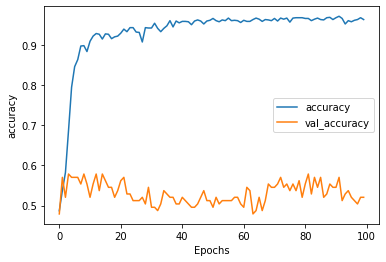

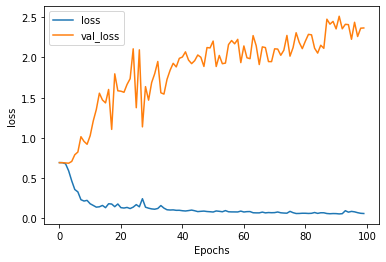

In [17]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [18]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [20]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [21]:
import io

out_v = io.open('vecs_.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [23]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs_.tsv')
  files.download('meta_.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>